<a href="https://colab.research.google.com/github/corentinsup/IPEO-Project/blob/main/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Glacier Segmentation - Inference Notebook

We assume that this notebook **will be run using colab**, so we clone the repository in the notebook directly. If you run it locally, you can **skip the first cell**



In [44]:
!git clone https://github.com/corentinsup/IPEO-Project.git
# Changing the working directory to the repo
import os
os.chdir("/content/IPEO-Project")


fatal: destination path 'IPEO-Project' already exists and is not an empty directory.


Now that the repository is loaded on colab, we download the required libraries. (also needed locally)

In [45]:
%pip install -r requirements_loose.txt

## Model weights
The weights of the model we trained are available in the following [Google drive folder](https://drive.google.com/drive/folders/1s2sYuB6vzGHPIqQxNUA89A3WhCYyzieL?usp=sharing).

They should be placed in the [checkpoints](./checkpoints) folder. The following snipper will automatically download them if the folder is empty.

In [46]:
import glob
# PATHS AND URLS
CHECKPOINT_DIR = "./checkpoints"
DINO_WEIGHTS_ID = "1nsFGpaYvxRG183cUwaQaYMTuiPmGbnoT"
UNET_WEIGHTS_ID = "1mr2CLY_rAkEZho2RmoedDtUDEWcVjdRk"

files = glob.glob(os.path.join(CHECKPOINT_DIR, "*.pth"))
if len(files) == 0:
  import gdown
  gdown.download(id=DINO_WEIGHTS_ID, output=CHECKPOINT_DIR + "/dino_final_model.pth", quiet=False)
  gdown.download(id=UNET_WEIGHTS_ID, output=CHECKPOINT_DIR + "/unet_final_model.pth", quiet=False)
else:
  print("Weights already downloaded")

Weights already downloaded


## Dataset
The dataset has been pushed to the GitHub repository and you therefore don't need to download any additional data. It is located under the [./dataset](./dataset) directory.
- ./dataset/clean/... # The training set
- ./dataset/test/... # The testing set (we only use this one in this notebook)

In [47]:
# Data Paths
TEST_IMAGE_DIR  = f"dataset/test/images/"
TEST_MASK_DIR   = f"dataset/test/masks/"

## U-Net++ Inference
Here is the inference loop over the test dataset for the U-Net++ model.


In [48]:
# standard imports
import os
import torch
import numpy as np
import random
from tqdm import tqdm
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

# local imports
from models.utils.inference import run_eval
from models.DinoV3.SemanDino import GlacierSegmenter
from models.DinoV3.GlacierDataset import GlacierDataset
from models.utils.metrics import get_combined_loss, get_iou_metric

Inference:   0%|          | 0/24 [00:00<?, ?it/s]

Test Loss: 0.2696, Test IoU: 0.7771


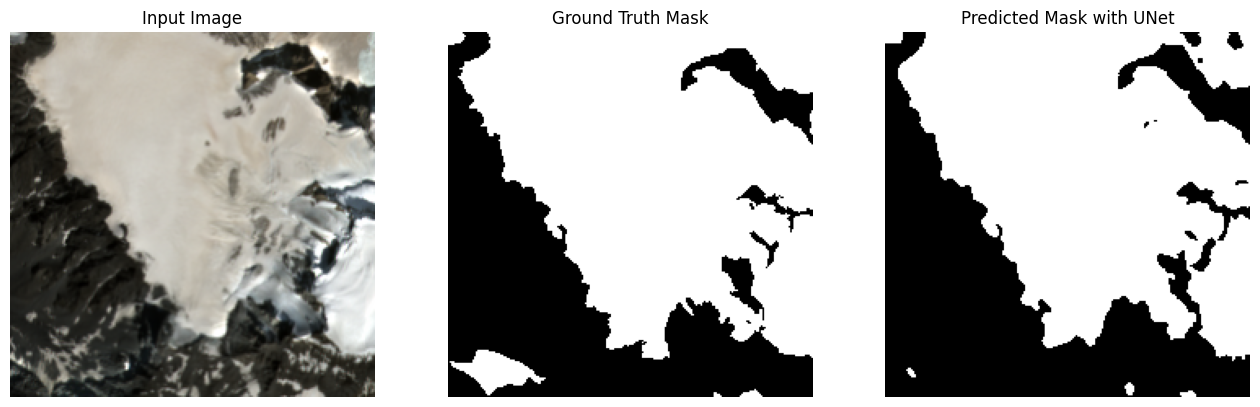

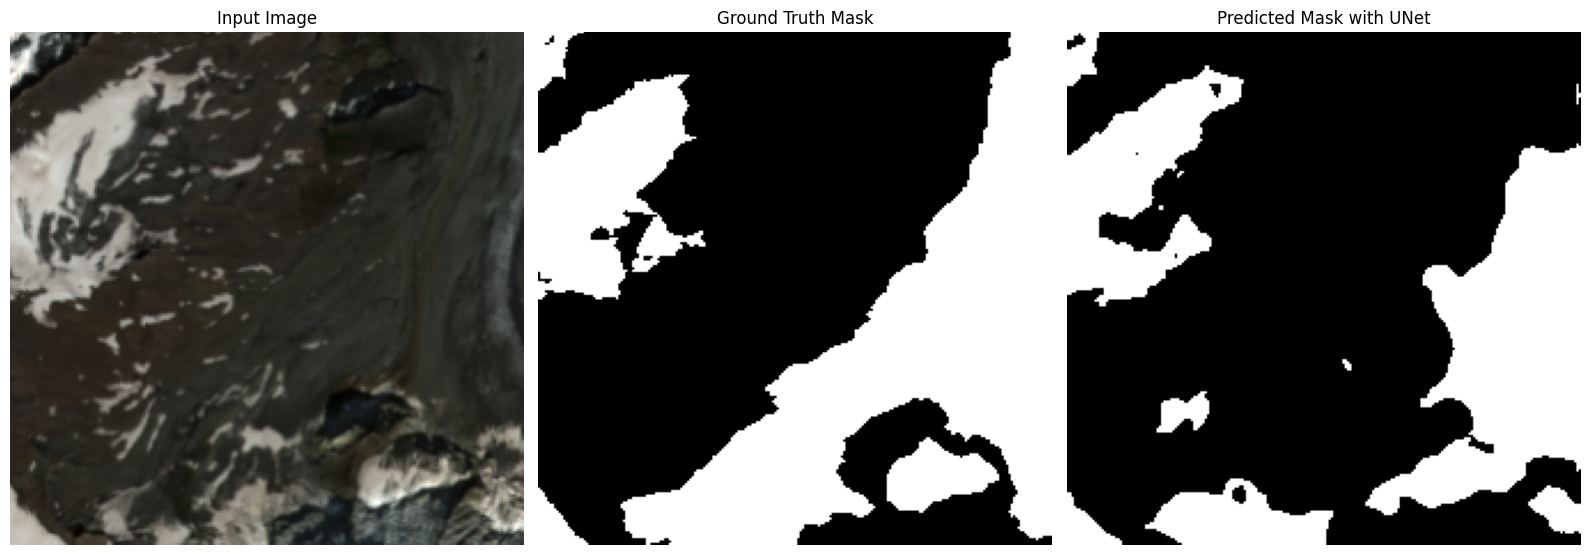

In [49]:
# Constants/Configuration
IGNORE_INDEX = 255
NUM_CLASS = 2
BATCH_SIZE = 8
NUM_WORKERS = 2 # DataLoader workers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# UNet Hyperparameters (Found during our cross validation experiments)
CE_WEIGHT_UNET = 0.5
DICE_WEIGHT_UNET = 0.5

# Model loading
unet_checkpoints_path = os.path.join(CHECKPOINT_DIR, f"unet_final_model.pth")
model_unet = smp.UnetPlusPlus(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            decoder_use_batchnorm=True,
            in_channels=3,
            classes=NUM_CLASS,
        ).to(device)

# Metrics
criterion_unet = get_combined_loss(CE_WEIGHT_UNET, DICE_WEIGHT_UNET, ignore_index=IGNORE_INDEX)
iou_metric_unet = get_iou_metric(ignore_index=IGNORE_INDEX)

model_unet.load_state_dict(torch.load(unet_checkpoints_path, map_location=device))

# Dataset Instantiation
test_ds_unet = GlacierDataset(
        image_dir=TEST_IMAGE_DIR,
        mask_dir=TEST_MASK_DIR,
        model="UNet", # required for correct data normalization (pretrained on ImageNet)
        mode="test",
    )

# Test DataLoader
test_loader_unet = DataLoader(
    test_ds_unet,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=False,
    persistent_workers=True,
    prefetch_factor=4
)

avg_loss_unet, avg_iou_unet, imgs_unet, masks_unet, preds_unet = run_eval(model_unet, test_loader_unet, criterion_unet, iou_metric_unet, return_preds=True, device=device)
print(f"Test Loss: {avg_loss_unet:.4f}, Test IoU: {avg_iou_unet:.4f}")

# Show a random segmentation
random.seed(42)
random_indices = random.sample(range(len(imgs_unet)), 2)
for idx in random_indices:
    # We revert the image's normalization
    img = test_ds_unet.denormalize(test_ds_unet[idx][0]).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    mask = masks_unet[idx]
    pred_u = preds_unet[idx]

    # display the prediction
    fig, axs = plt.subplots(1, 3, figsize=(16, 8))
    axs[0].imshow(img)
    axs[0].set_title("Input Image")
    axs[0].axis("off")
    axs[1].imshow(mask.squeeze().cpu(), cmap="gray", vmin=0, vmax=1)
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")
    axs[2].imshow(pred_u.squeeze().cpu(), cmap="gray", vmin=0, vmax=1)
    axs[2].set_title("Predicted Mask with UNet")
    axs[2].axis("off")
plt.tight_layout()
plt.show()



## Inference with the Dino Based Model
⚠️⚠️⚠️ To load the Dino model, we use **HuggingFace Hub**. To be able to run inference, you should have an account and login with your token (this can be done in the following cell). ⚠️⚠️⚠️

Moreover, the DinoV3 models **requires the users to request access** to the model. This can be done following [this link](https://huggingface.co/collections/facebook/dinov3), the approval of META should be given in less than 15 minutes (from our experience).


In [50]:
from huggingface_hub import notebook_login
notebook_login(new_session=False) # Will be skipped if already logged_in

Inference:   0%|          | 0/24 [00:00<?, ?it/s]

Test Loss: 0.2564, Test IoU: 0.7935


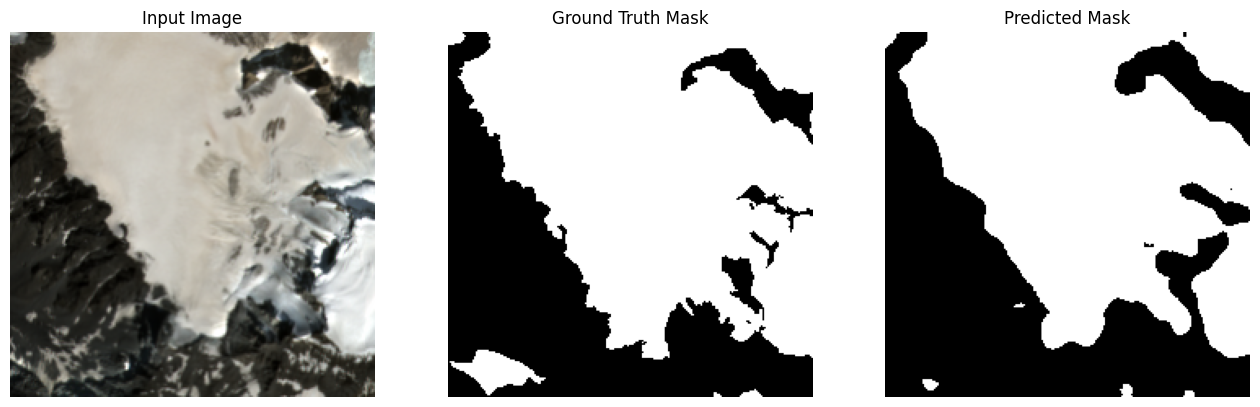

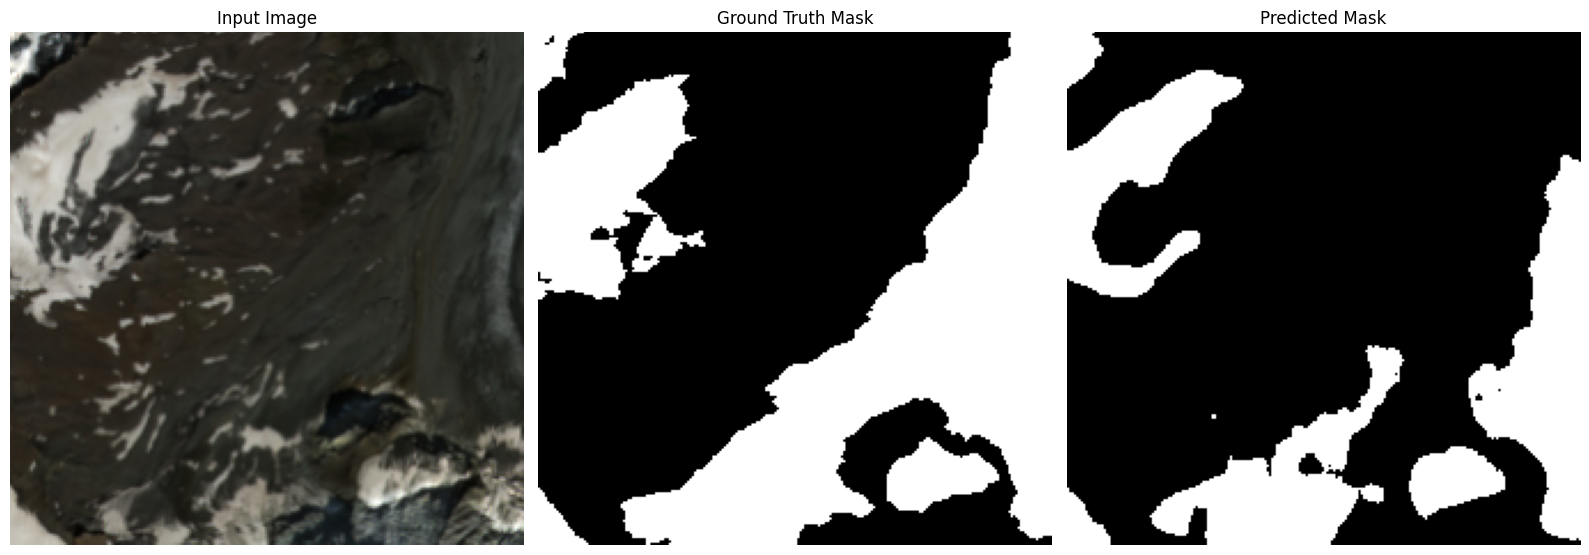

In [51]:
# Model hyperparameters (found using cross-validation)
CE_WEIGHT_SEMANDINO, DICE_WEIGHT_SEMANDINO = 0.5, 0.5

# Load Dino model
checkpoints_path_dino = os.path.join(CHECKPOINT_DIR, f"dino_final_model.pth")
model_dino = GlacierSegmenter(num_classes=NUM_CLASS).to(device)

criterion_dino = get_combined_loss(CE_WEIGHT_SEMANDINO, DICE_WEIGHT_SEMANDINO, ignore_index=IGNORE_INDEX)
iou_metric_dino = get_iou_metric(ignore_index=IGNORE_INDEX)

# load weights
model_dino.load_state_dict(torch.load(checkpoints_path_dino, map_location=device))

# Create Test Dataset for Dino model
test_ds_dino = GlacierDataset(
        image_dir=TEST_IMAGE_DIR,
        mask_dir=TEST_MASK_DIR,
        model="DinoV3",
        mode="test",
)

# Test DataLoader for Dino model
test_loader_dino = DataLoader(
    test_ds_dino,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=False,
    persistent_workers=True,
    prefetch_factor=4
)


avg_loss_dino, avg_iou_dino, imgs_dino, masks_dino, preds_dino = run_eval(model_dino, test_loader_dino, criterion_dino, iou_metric_dino, return_preds=True, device=device)
print(f"Test Loss: {avg_loss_dino:.4f}, Test IoU: {avg_iou_dino:.4f}")

# Show a random segmentation
random.seed(42)
random_indices = random.sample(range(len(imgs_unet)), 2)
for idx in random_indices:
    # We revert the image's normalization
    img = test_ds_dino.denormalize(test_ds_dino[idx][0]).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    mask = masks_dino[idx]
    pred = preds_dino[idx]


    # display the prediction
    fig, axs = plt.subplots(1, 3, figsize=(16, 8))
    axs[0].imshow(img)
    axs[0].set_title("Input Image")
    axs[0].axis("off")
    axs[1].imshow(mask.squeeze().cpu(), cmap="gray", vmin=0, vmax=1)
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")
    axs[2].imshow(pred.squeeze().cpu(), cmap="gray", vmin=0, vmax=1)
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")
plt.tight_layout()
plt.show()




## Prediction comparison
Here you can see side-by-side the predictions done with the U-Net and Dino model.



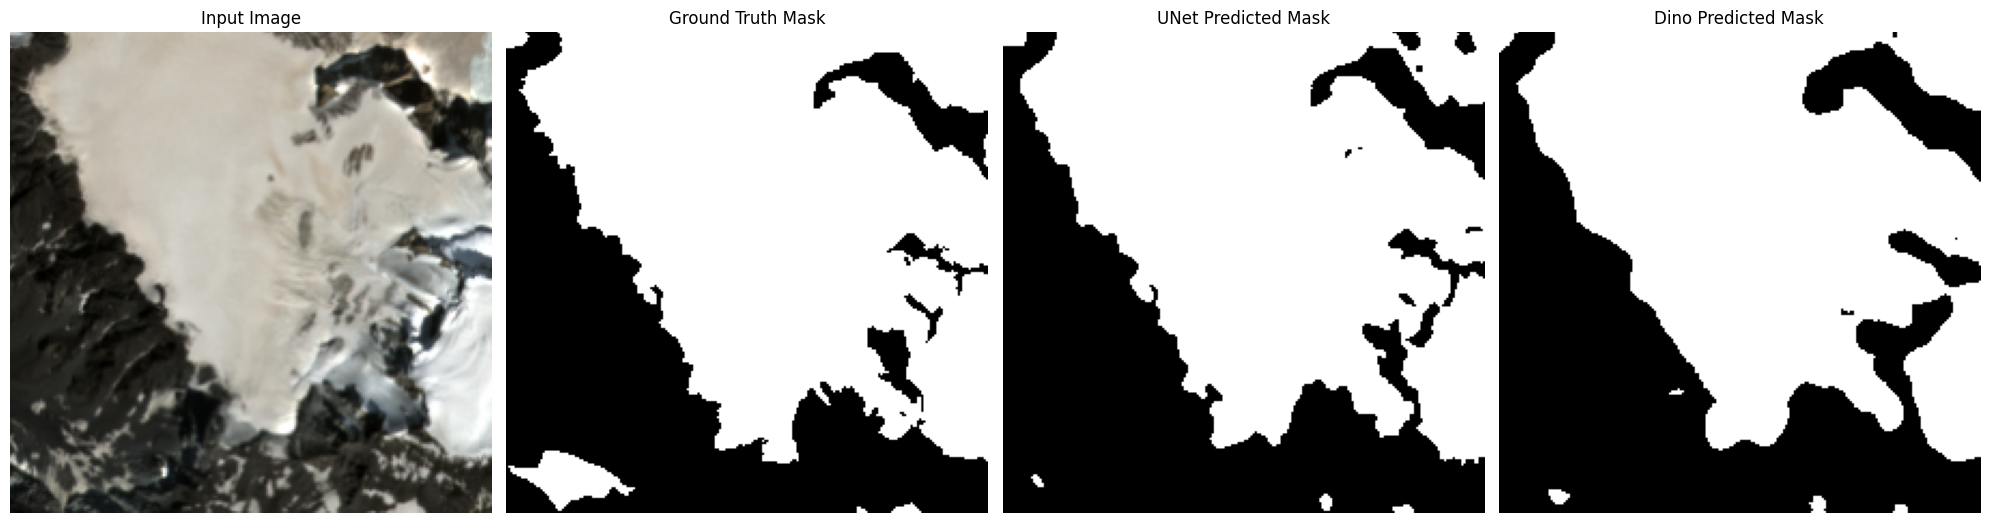

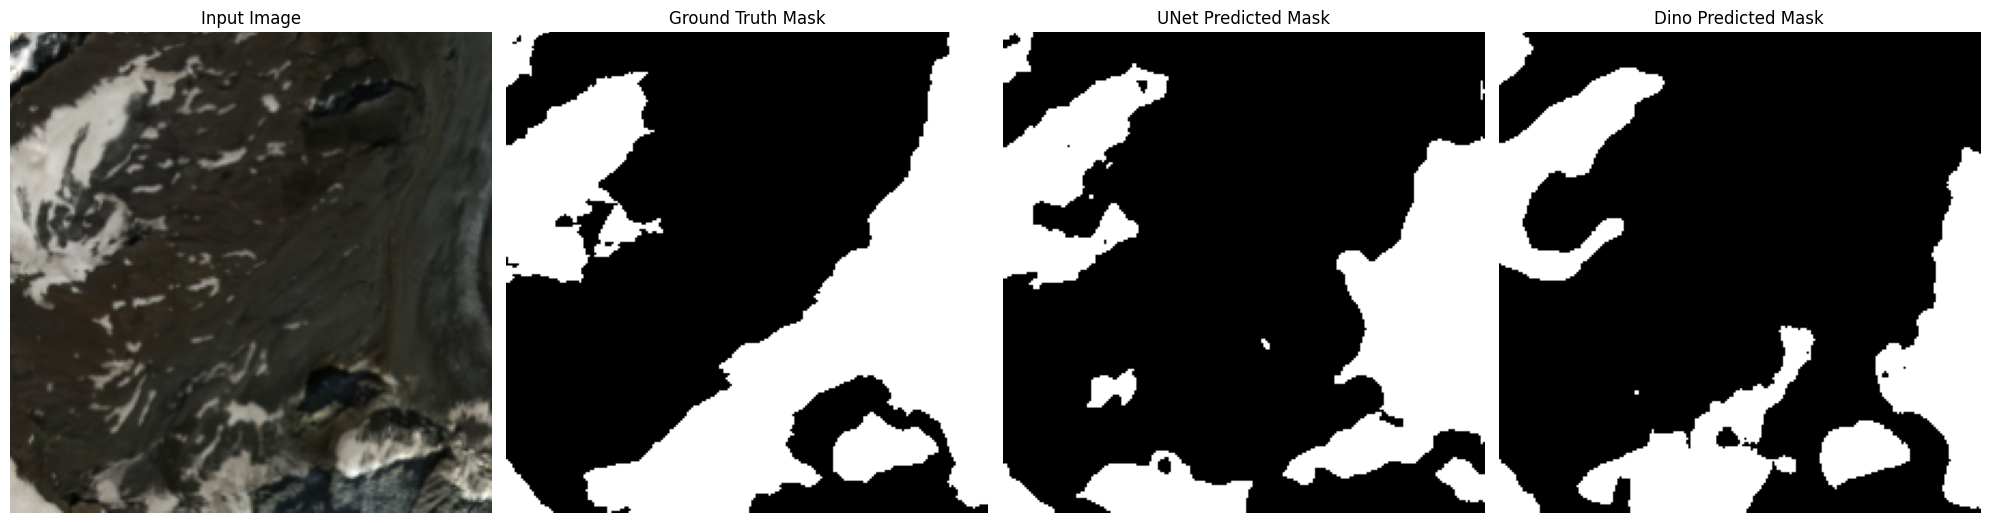

In [52]:
random.seed(42) # To have the same images each time -> comparison
random_indices = random.sample(range(len(test_ds_unet)), 2) # Get 2 random indices

for idx in random_indices:
    # (both models are not using the same mean and stds for the normalization!)
    # Denormalize the original image from the dataset for UNet
    img_unet_display = test_ds_unet.denormalize(test_ds_unet[idx][0]).permute(1, 2, 0).numpy()
    img_unet_display = np.clip(img_unet_display, 0, 1)
    # Denormalize the original image from the dataset for Dino
    img_dino_display = test_ds_dino.denormalize(test_ds_dino[idx][0]).permute(1, 2, 0).numpy()
    img_dino_display = np.clip(img_dino_display, 0, 1)


    # Get the corresponding masks and predictions
    mask_unet = masks_unet[idx]
    pred_unet = preds_unet[idx]

    mask_dino = masks_dino[idx]
    pred_dino = preds_dino[idx]

    fig, axs = plt.subplots(1, 4, figsize=(20, 10))

    axs[0].imshow(img_unet_display)
    axs[0].set_title("Input Image")
    axs[0].axis("off")

    axs[1].imshow(mask_unet.squeeze().cpu(), cmap="gray", vmin=0, vmax=1)
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")

    axs[2].imshow(pred_unet.squeeze().cpu(), cmap="gray", vmin=0, vmax=1)
    axs[2].set_title("UNet Predicted Mask")
    axs[2].axis("off")

    axs[3].imshow(pred_dino.squeeze().cpu(), cmap="gray", vmin=0, vmax=1)
    axs[3].set_title("Dino Predicted Mask")
    axs[3].axis("off")

    plt.tight_layout()
    plt.show()